In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import os

In [ ]:
path = "/content/drive/MyDrive/DATASET FP/bismillah data gas.csv"
df = pd.read_csv(path)

In [ ]:
df

,country,date,sector,GWh
0,Mexico,1/1/2020,Gas,433.181
1,Mexico,2/1/2020,Gas,441.637
2,Mexico,3/1/2020,Gas,448.023
3,Mexico,4/1/2020,Gas,453.059
4,Mexico,5/1/2020,Gas,450.609
...,...,...,...,...
1940,Mexico,26/04/2025,Gas,649.285
1941,Mexico,27/04/2025,Gas,651.161
1942,Mexico,28/04/2025,Gas,650.995
1943,Mexico,29/04/2025,Gas,654.125


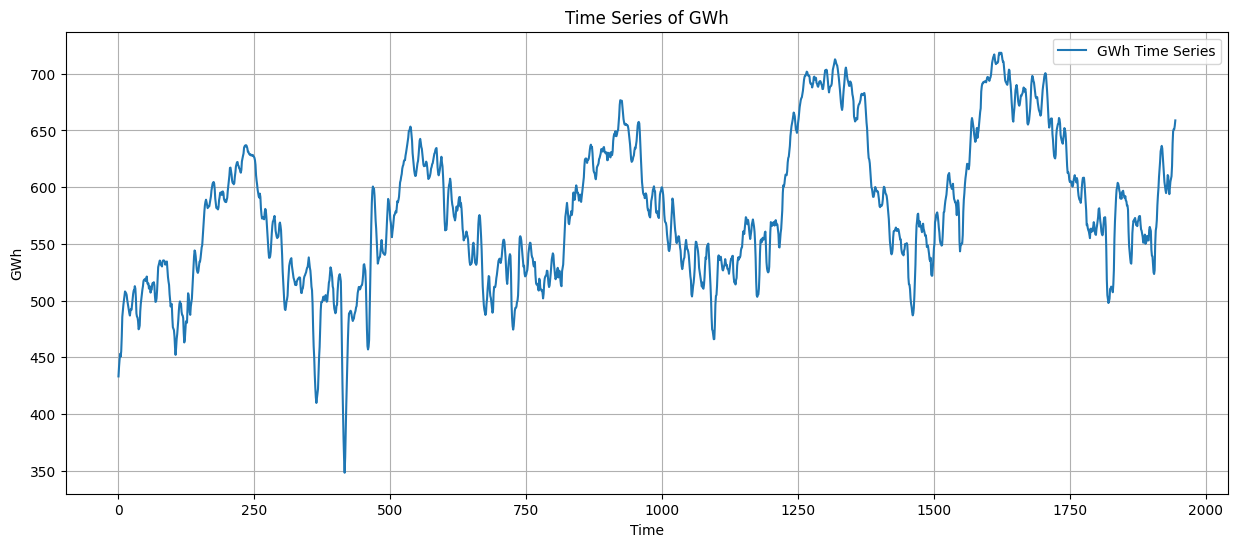

In [ ]:
# prompt: plot time series GWh

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(df["GWh"], label='GWh Time Series')
plt.xlabel('Time')
plt.ylabel('GWh')
plt.title('Time Series of GWh')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['GWh']])

In [ ]:
lookback_window = 30

In [ ]:
import numpy as np
from tqdm import tqdm

x = []
y = []
for i in tqdm(range(lookback_window, len(df_scaled))):
    x.append(df_scaled[i - lookback_window:i])
    y.append(df_scaled[i])

x = np.array(x)
y = np.array(y)
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

100%|██████████| 1915/1915 [00:00<00:00, 472670.64it/s]


In [ ]:
train_size = int(len(x) * 0.8)
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    input_layer = Input(shape=(lookback_window, 1))

    # LSTM layer
    lstm_units = hp.Choice('lstm_units', values=[32, 64, 128])
    lstm_layer = LSTM(
        units=lstm_units,
        return_sequences=False
    )(input_layer)

    # Optional dropout
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    dropout = Dropout(dropout_rate)(lstm_layer)

    # Output layer
    output_layer = Dense(1, activation='linear')(dropout)

    # Build model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )

    return model

In [ ]:
from keras_tuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,                      # Fungsi build_model untuk LSTM
    objective='val_loss',            # Fokus optimasi: minimalkan val_loss
    max_trials=50,                   # Coba 50 kombinasi hyperparameter
    executions_per_trial=1,         # Setiap kombinasi dijalankan 1x
    directory='lstm_tuning',        # Folder penyimpanan hasil tuning
    project_name='lstm_forecast'    # Nama proyek tuning
)


In [ ]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # dari 10 → 5

tuner.search(x_train, y_train,
             validation_data=(x_val, y_val),
             epochs=30,          # dari 100 → 30
             batch_size=32,
             callbacks=[early_stop],
             verbose=1)


Trial 50 Complete [00h 00m 44s]
val_loss: 0.0003206313122063875

Best val_loss So Far: 0.0002824341645464301
Total elapsed time: 00h 42m 19s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print("LSTM Units    :", best_hp.get('lstm_units'))
print("Dropout       :", best_hp.get('dropout_rate'))
print("Learning Rate :", best_hp.get('learning_rate'))


Best Hyperparameters:
LSTM Units    : 32
Dropout       : 0.1
Learning Rate : 0.006147242799935061


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Bisa disesuaikan, misal 10–15
    restore_best_weights=True
)

# Train best LSTM model
history = best_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.0022 - mae: 0.0346 - val_loss: 3.7616e-04 - val_mae: 0.0150
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.4614e-04 - mae: 0.0209 - val_loss: 3.4408e-04 - val_mae: 0.0144
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 7.2347e-04 - mae: 0.0201 - val_loss: 8.8759e-04 - val_mae: 0.0260
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.1645e-04 - mae: 0.0192 - val_loss: 3.0514e-04 - val_mae: 0.0134
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.3128e-04 - mae: 0.0195 - val_loss: 3.0789e-04 - val_mae: 0.0136
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.8404e-04 - mae: 0.0187 - val_loss: 2.9865e-04 - val_mae: 0.0132
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 5.5541e-04 - mae: 0.0182 - val_loss: 3.1797e-04 - val_mae: 0.0137
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 5.2536e-04 - mae: 0.0175 - val_loss: 3.4803e-04 - val_mae: 0.0149
Epoc

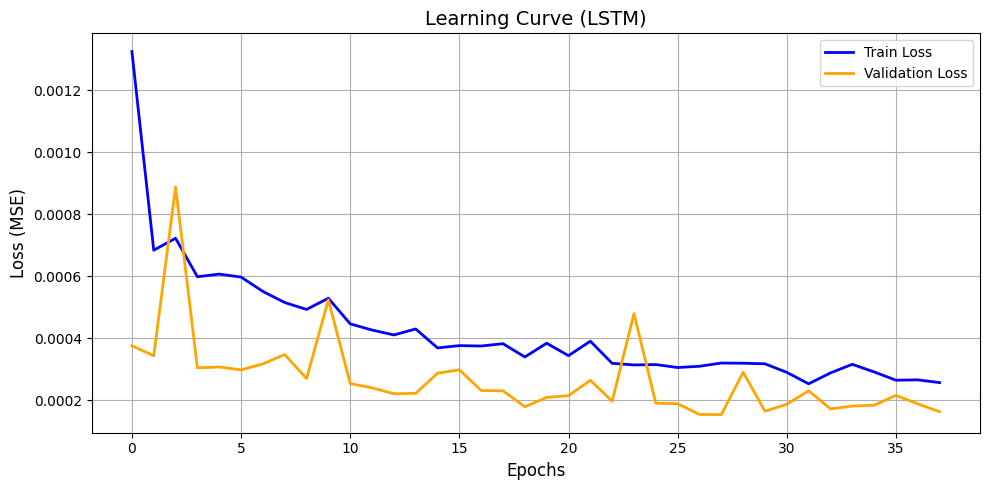

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Learning Curve (LSTM)', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Prediksi menggunakan model LSTM
predict = best_model.predict(x_val)

# Inverse scaling hasil prediksi dan data asli
predict_original_scale = scaler.inverse_transform(predict)
y_val_original_scale = scaler.inverse_transform(y_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Flatten hasil untuk evaluasi
y_flat = y_val_original_scale.reshape(-1)
predict_flat = predict_original_scale.reshape(-1)

# Evaluasi performa
mape_value = mean_absolute_percentage_error(y_flat, predict_flat) * 100
r2_value = r2_score(y_flat, predict_flat)

print(f'MAPE on Testing Data: {mape_value:.4f}%')
print(f'R2 Score on Testing Data: {r2_value:.4f}')

MAPE on Testing Data: 0.5492%
R2 Score on Testing Data: 0.9934


In [ ]:
# Evaluasi pada training data (LSTM)

# Prediksi data training
predict_train = best_model.predict(x_train)
predict_train_original_scale = scaler.inverse_transform(predict_train)
y_train_original_scale = scaler.inverse_transform(y_train)

# Flatten untuk evaluasi
y_train_flat = y_train_original_scale.reshape(-1)
predict_train_flat = predict_train_original_scale.reshape(-1)

# Evaluasi performa
mape_train = mean_absolute_percentage_error(y_train_flat, predict_train_flat) * 100
r2_train = r2_score(y_train_flat, predict_train_flat)

print(f'MAPE on Training Data: {mape_train:.4f}%')
print(f'R2 Score on Training Data: {r2_train:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MAPE on Training Data: 0.5905%
R2 Score on Training Data: 0.9946


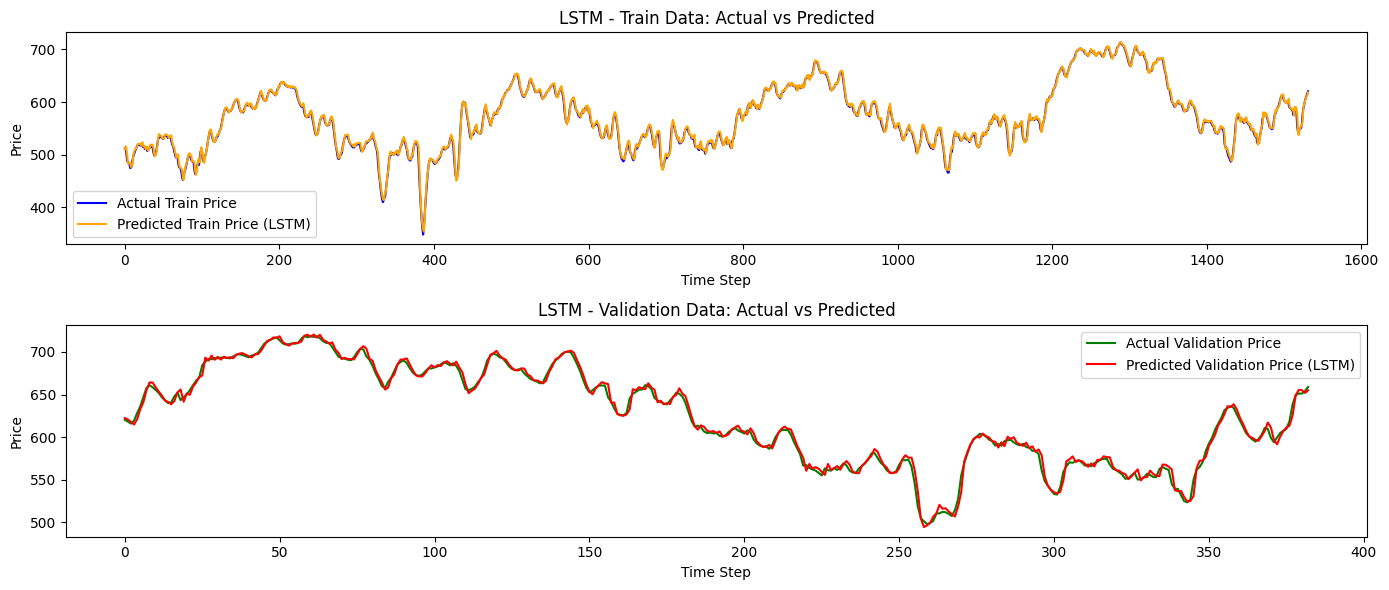

In [ ]:
# Plot hasil prediksi LSTM
plt.figure(figsize=(14, 6))

# Plot data training
plt.subplot(2, 1, 1)
plt.plot(y_train_original_scale, label='Actual Train Price', color='blue')
plt.plot(predict_train_original_scale, label='Predicted Train Price (LSTM)', color='orange')
plt.title('LSTM - Train Data: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()

# Plot data validasi
plt.subplot(2, 1, 2)
plt.plot(y_val_original_scale, label='Actual Validation Price', color='green')
plt.plot(predict_original_scale, label='Predicted Validation Price (LSTM)', color='red')
plt.title('LSTM - Validation Data: Actual vs Predicted')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

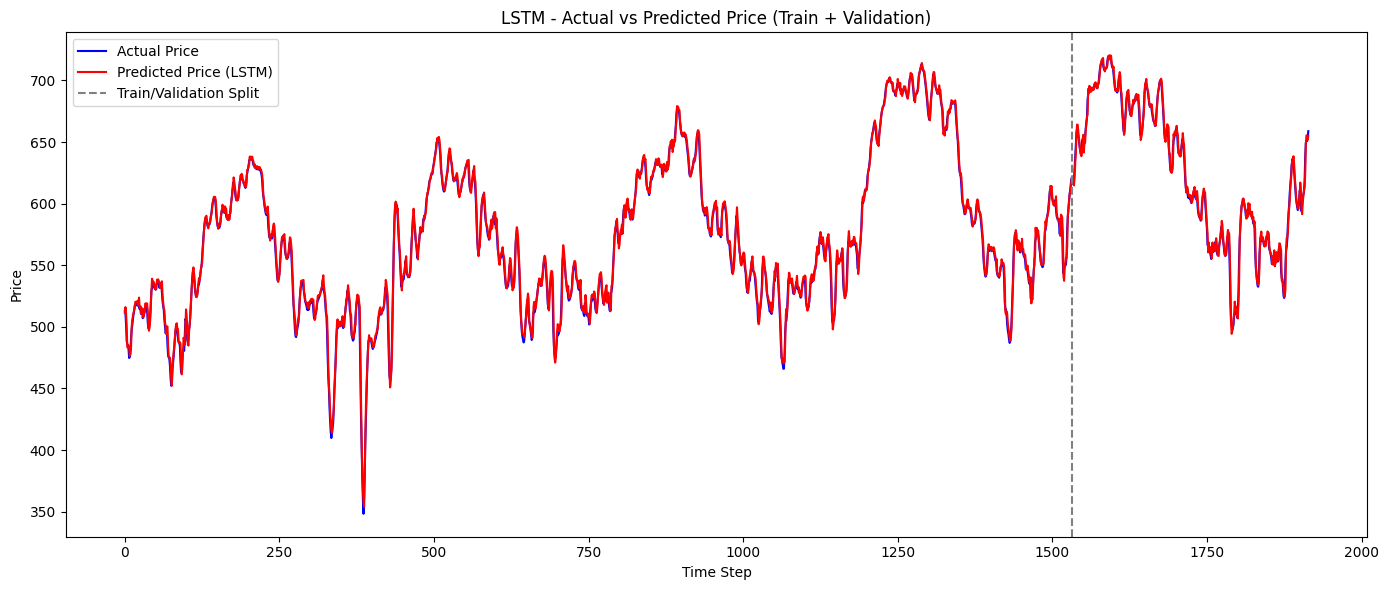

In [ ]:
# Gabungkan data asli dan prediksi untuk LSTM
full_actual = np.concatenate((y_train_original_scale, y_val_original_scale))
full_predict = np.concatenate((predict_train_original_scale, predict_original_scale))

# Plot hasil prediksi keseluruhan (train + validation)
plt.figure(figsize=(14, 6))
plt.plot(full_actual, label='Actual Price', color='blue')
plt.plot(full_predict, label='Predicted Price (LSTM)', color='red')
plt.axvline(x=len(y_train_original_scale), color='gray', linestyle='--', label='Train/Validation Split')
plt.title('LSTM - Actual vs Predicted Price (Train + Validation)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

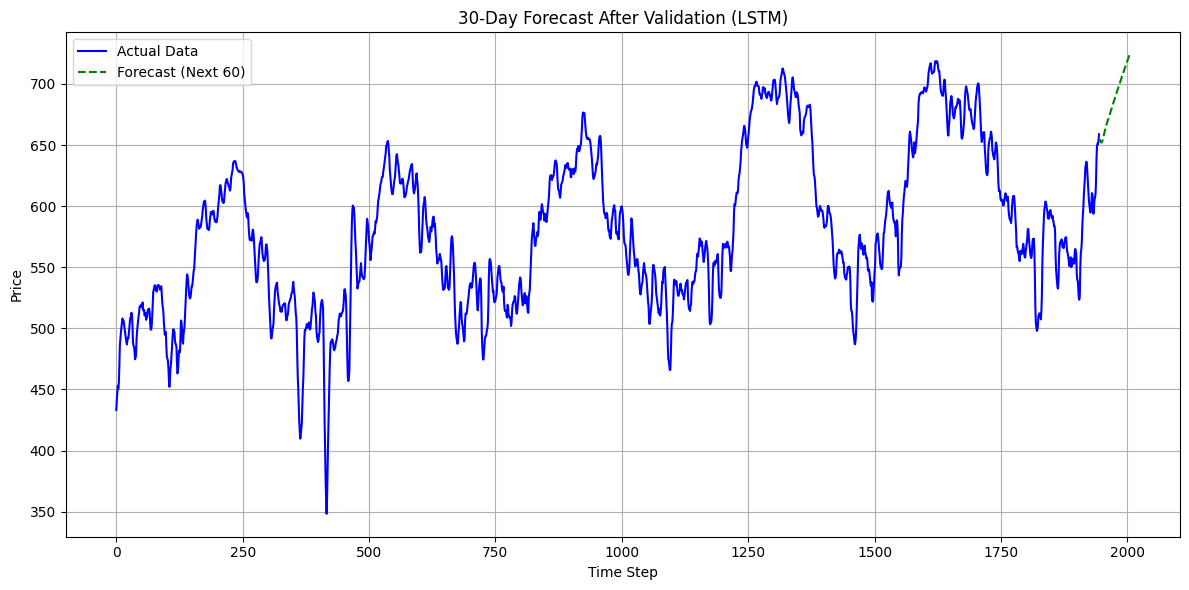

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Asumsikan x_val, scaler, dan best_model sudah tersedia dari pelatihan
n_forecast = 60
forecast_input = x_val[-1].reshape(1, x_val.shape[1], 1)

future_forecast_scaled = []

for _ in range(n_forecast):
    pred = best_model.predict(forecast_input, verbose=0)
    future_forecast_scaled.append(pred[0, 0])

    # Geser window dan tambahkan prediksi
    new_input = np.append(forecast_input[0, 1:], [[pred[0, 0]]], axis=0)
    forecast_input = new_input.reshape(1, new_input.shape[0], 1)

# Transform balik hasil prediksi
future_forecast_scaled = np.array(future_forecast_scaled).reshape(-1, 1)
future_forecast = scaler.inverse_transform(future_forecast_scaled)

# Ambil data aktual (pastikan ini numerik)
actual_data = df['GWh'].values.flatten()  # Ganti 'Gwh' kalau kolommu beda

# Plot hasil
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_data)), actual_data, label='Actual Data', color='blue')

forecast_range = range(len(actual_data), len(actual_data) + n_forecast)
plt.plot(forecast_range, future_forecast, label='Forecast (Next 60)', color='green', linestyle='--')

plt.title('30-Day Forecast After Validation (LSTM)')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
import numpy as np
import joblib
import os
import tensorflow as tf
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.losses import MeanSquaredError  # Untuk custom_objects saat load model

# Buat direktori simpan
save_dir = 'lstm_model_and_data'
os.makedirs(save_dir, exist_ok=True)

# ====================
# 1. Simpan data aktual dan prediksi
# ====================

# Data aktual
np.save(os.path.join(save_dir, 'y_train_actual.npy'), y_train_original_scale)
np.save(os.path.join(save_dir, 'y_val_actual.npy'), y_val_original_scale)

# Data prediksi
np.save(os.path.join(save_dir, 'y_train_predicted.npy'), predict_train_original_scale)
np.save(os.path.join(save_dir, 'y_val_predicted.npy'), predict_original_scale)

# ====================
# 2. Simpan hasil forecast masa depan
# ====================
np.save(os.path.join(save_dir, 'future_forecast.npy'), future_forecast)

# ====================
# 3. Simpan model LSTM
# ====================
model_path = os.path.join(save_dir, 'best_lstm_model.keras')  # format .keras (modern) atau .h5 (legacy)
save_model(best_model, model_path)

# ====================
# 4. Simpan scaler
# ====================
scaler_path = os.path.join(save_dir, 'scaler.pkl')
joblib.dump(scaler, scaler_path)

# ====================
# 5. Simpan hyperparameters (opsional)
# ====================
best_hp_dict = {
    'lstm_units': best_hp.get('lstm_units'),
    'dropout_rate': best_hp.get('dropout_rate'),
    'learning_rate': best_hp.get('learning_rate'),
}
joblib.dump(best_hp_dict, os.path.join(save_dir, 'best_hyperparameters.pkl'))

print("\n✅ Semua file berhasil disimpan ke folder:", save_dir)

# ====================
# Cara Meload Kembali
# ====================

# Load data
loaded_y_train_actual = np.load(os.path.join(save_dir, 'y_train_actual.npy'))
loaded_y_val_actual = np.load(os.path.join(save_dir, 'y_val_actual.npy'))
loaded_y_train_predicted = np.load(os.path.join(save_dir, 'y_train_predicted.npy'))
loaded_y_val_predicted = np.load(os.path.join(save_dir, 'y_val_predicted.npy'))
loaded_future_forecast = np.load(os.path.join(save_dir, 'future_forecast.npy'))

# Load model (LSTM tidak butuh custom_objects, kecuali pakai loss/metric custom)
loaded_model = load_model(model_path)

# Load scaler dan hyperparameter
loaded_scaler = joblib.load(scaler_path)
loaded_hp = joblib.load(os.path.join(save_dir, 'best_hyperparameters.pkl'))

# Cek hasil load
print("\n✅ Files loaded successfully:")
print("Loaded validation actual shape:", loaded_y_val_actual.shape)
print("Loaded future forecast shape:", loaded_future_forecast.shape)
print("Loaded hyperparameters:", loaded_hp)
print("Scaler type:", type(loaded_scaler))

# Cek struktur model
loaded_model.summary()


✅ Semua file berhasil disimpan ke folder: lstm_model_and_data

✅ Files loaded successfully:
Loaded validation actual shape: (383, 1)
Loaded future forecast shape: (30, 1)
Loaded hyperparameters: {'lstm_units': 32, 'dropout_rate': 0.1, 'learning_rate': 0.006147242799935061}
Scaler type: <class 'sklearn.preprocessing._data.MinMaxScaler'>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,157 (51.40 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,772 (34.27 KB)

In [48]:
# prompt: mape dan r square training

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Evaluasi pada training data
predict_train = best_model.predict(x_train)
predict_train_original_scale = scaler.inverse_transform(predict_train)
y_train_original_scale = scaler.inverse_transform(y_train)

# Flatten untuk evaluasi training
y_train_flat = y_train_original_scale.reshape(-1)
predict_train_flat = predict_train_original_scale.reshape(-1)

# Evaluasi performa pada training data
mape_train = mean_absolute_percentage_error(y_train_flat, predict_train_flat) * 100
mae = np.mean(np.abs(predict_train_flat - y_train_flat))
rmse = np.sqrt(mean_squared_error(y_train_flat, predict_train_flat))
r2_train = r2_score(y_train_flat, predict_train_flat)

print(f'MAPE on Training Data: {mape_train:.4f}%')
print(f'MAE on Training Data: {mae:.4f}')
print(f'RMSE on Training Data: {rmse:.4f}')
print(f'R2 Score on Training Data: {r2_train:.4f}')

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
MAPE on Training Data: 0.5905%
MAE on Training Data: 3.2367
RMSE on Training Data: 4.3900
R2 Score on Training Data: 0.9946


In [49]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Flatten untuk evaluasi
y_flat = y_val_original_scale.reshape(-1)
predict_flat = predict_original_scale.reshape(-1)

# Evaluasi performa
mape_value = mean_absolute_percentage_error(y_flat, predict_flat) * 100
mae = np.mean(np.abs(predict_flat - y_flat))
rmse = sqrt(mean_squared_error(y_flat, predict_flat))
r2_value = r2_score(y_flat, predict_flat)

print(f'MAPE on Testing Data: {mape_value:.4f}%')
print(f'MAE on Testing Data: {mae:.4f}')
print(f'RMSE on Testing Data: {rmse:.4f}')
print(f'R2 Score on Testing Data: {r2_value:.4f}')

MAPE on Testing Data: 0.5492%
MAE on Testing Data: 3.3344
RMSE on Testing Data: 4.6053
R2 Score on Testing Data: 0.9934
